In [34]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, GridSearchCV
from mlxtend.evaluate import feature_importance_permutation
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load, split and scale data

In [2]:
#creating a dataframe in pandas
heads = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
         'chlorides', "free sulfur dioxide", 'total sulfur dioxide', 'density',
         'pH', 'sulphates', 'alcohol', 'quality']

d_train = pd.read_csv('/content/drive/MyDrive/AMATH/wine_training.csv', header=None)#; d_train.columns = heads
d_test = pd.read_csv('/content/drive/MyDrive/AMATH/wine_test.csv', header=None)#; d_test.columns = heads

# Splitting training and testing sets
X_train = d_train.iloc[:, 0:11].values; Y_train = d_train.iloc[:, 11].values
X_test = d_test.iloc[:, 0:11].values  ; Y_test = d_test.iloc[:, 11].values

# normalizing data, (mean 0, std 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train); X_test = sc.transform(X_test)

Text(0.5, 1.0, 'Correlation Matrix for Features')

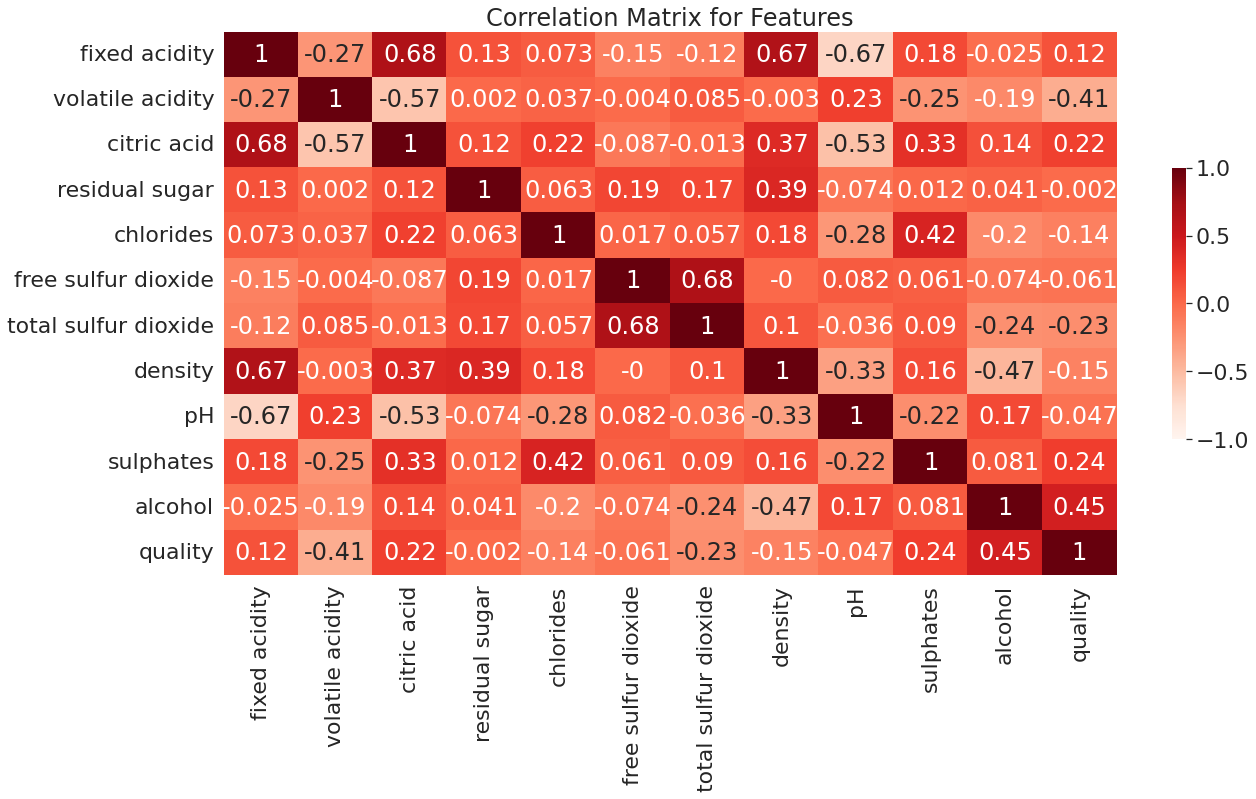

In [3]:
# identify which physical properties are the ones that affect quality the most. 
correlat = d_train.corr().round(3)
fig = plt.figure(figsize=(20,10)); sns.set(font_scale=2)

sns.heatmap(correlat, vmin=-1,vmax=1, square=False, annot=True, cmap='Reds', xticklabels=heads, yticklabels=heads, cbar_kws={"shrink": 0.5} )
plt.title('Correlation Matrix for Features')

# Linear Regression, RBF and LaPlace model fitting with 10-Fold Cross Validation

In [4]:
# Model fitting
lr  = RidgeCV(alphas=1.0).fit(X_train, Y_train)
rbf = KernelRidge(kernel = 'rbf').fit(X_train, Y_train)
lap = KernelRidge(kernel = 'laplacian').fit(X_train, Y_train)

# Put the models in a list to be used for Cross-Validation
models = [lr, rbf, lap]

def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

# Run the Cross-Validation comparison with the models used in this analysis
old_comp, maes, mses, r2s, accs = cv_comparison(models, X_train, Y_train, 10)
old_comp

,RidgeCV(alphas=array(1.)),KernelRidge(kernel='rbf'),KernelRidge(kernel='laplacian')
Mean Absolute Error,0.4942,0.5949,0.4798
Mean Squared Error,0.4126,0.7011,0.4013
R^2,0.3400,-0.1280,0.3626
Accuracy,91.2345,89.4487,91.4914


In [5]:
lr.alpha_

1.0

Tuning Hyperparameters

In [6]:
#Grid Search for rbf, laplacian hyper params
from sklearn.model_selection import GridSearchCV
parameters = [{"alpha": [10,5.0,1,0.1,0.01,0.001,0.0001,0], 'kernel': ['rbf', 'laplacian'], 'gamma': np.linspace(0, 0.5, num=10)}]
                                    
grid_search = GridSearchCV(estimator = KernelRidge(),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10,
                           n_jobs= -1)
grid_search = grid_search.fit(X_train, Y_train)
grid_results = pd.DataFrame(grid_search.cv_results_, 
                            columns= ['mean_fit_time', 'param_alpha',	
                                      'param_gamma',	'param_kernel', 
                                  'mean_test_score', 'rank_test_score'])
grid_results.columns = ['model_time', 'alphas', 'gammas', 'kernel', 'score', 'rank']
top_params = grid_results.sort_values('score').drop_duplicates('kernel', keep='last').sort_index().sort_values('score', ascending=False)
print(top_params) 

# search for best linear alphas params
lr_cv  = RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0], cv=10).fit(X_train, Y_train)
print('best alpha: ', lr_cv.alpha_)

# Put the new models in a list to be used for Cross-Validation
lr  = RidgeCV(alphas=10).fit(X_train, Y_train)
rbf = KernelRidge(kernel = 'rbf', alpha = 0.1, gamma=0.055556).fit(X_train, Y_train)
lap = KernelRidge(kernel = 'laplacian', alpha = 0.1, gamma=0.055556).fit(X_train, Y_train)

models = [lr, rbf, lap]
new_comp, maes, mses, r2s, accs = cv_comparison(models, X_train, Y_train, 10)
new_comp

    model_time alphas    gammas     kernel     score  rank
63    0.094558    0.1  0.055556  laplacian -0.360023     1
62    0.094175    0.1  0.055556        rbf -0.435076    18
best alpha:  10.0


,RidgeCV(alphas=array(10)),"KernelRidge(alpha=0.1, gamma=0.055556, kernel='rbf')","KernelRidge(alpha=0.1, gamma=0.055556, kernel='laplacian')"
Mean Absolute Error,0.4942,0.4862,0.4462
Mean Squared Error,0.4124,0.4351,0.3600
R^2,0.3405,0.3027,0.4277
Accuracy,91.2345,91.3774,92.0868


# Predicting on New Batch using New Models

In [13]:
#load data + scale
new_batch = pd.read_csv('/content/drive/MyDrive/AMATH/wine_new_batch.csv', header=None)
new_X = sc.transform(new_batch)

# Qualities output for linear, rbf, and laplace
pred_test_lr = lr.predict(new_X); pred_test_rbf = rbf.predict(new_X); pred_test_lap = lap.predict(new_X)

q = np.column_stack((pred_test_lr, pred_test_rbf, pred_test_lap))
q_labels = ['predictive_qualities_linear', 'predictive_qualities_rbf' , 'predictive_qualities_laplace']
q = pd.DataFrame(q); q.columns = q_labels
q

,predictive_qualities_linear,predictive_qualities_rbf,predictive_qualities_laplace
0,6.012063,6.144831,6.212341
1,5.299380,4.147743,5.220916
2,5.563360,5.172856,5.564231
3,6.079660,5.277927,5.689044
4,5.955461,5.503194,5.654128


In [24]:
new_batch.columns = heads[0:11]

Text(0, 0.5, 'feature')

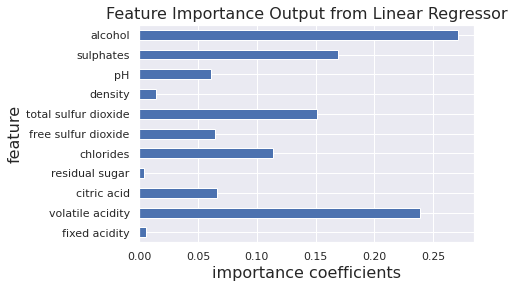

In [44]:
# feature importance from fitted linear model
sns.set(font_scale=1)
pd.Series(abs(lr.coef_), index=new_batch.columns).plot(kind='barh')
plt.title('Feature Importance Output from Linear Regressor', fontsize=16)
plt.xlabel('importance coefficients', fontsize=16)
plt.ylabel('feature', fontsize=16)